# Data Types

## Table of Contents 
* [defaults](#defaults)
* [upcasting](#upcasting)
* [astype](#astype)
* [object conversion](#object_conversion)
* [gotchas](#gotchas)
* [Selecting columns based on ](#selecting_columns_based_on_)

---

In [2]:
import pandas as pd
import numpy as np

For the most part, pandas uses NumPy arrays and dtypes for Series or individual
columns of a DataFrame. NumPy provides support for `float`,
`int`, `bool`, `timedelta64[ns]` and `datetime64[ns]` (note that NumPy
does not support timezone-aware datetimes).

pandas and third-party libraries *extend* NumPy’s type system in a few places.
This section describes the extensions pandas has made internally.
See [Extension types](https://pandas.pydata.org/docs/development/extending.html#extending-extension-types) for how to write your own extension that
works with pandas. See [Extension data types](https://pandas.pydata.org/docs/ecosystem.html#ecosystem-extensions) for a list of third-party
libraries that have implemented an extension.

The following table lists all of pandas extension types. For methods requiring `dtype`
arguments, strings can be specified as indicated. See the respective
documentation sections for more on each type.

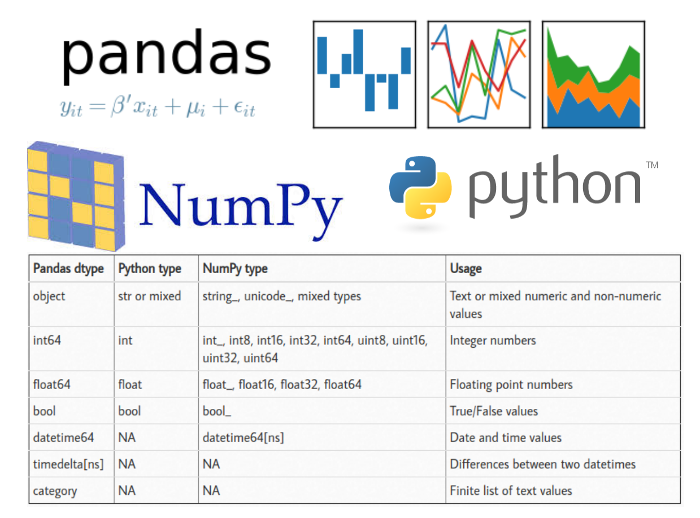

pandas has two ways to store strings.
- `object` dtype, which can hold any Python object, including strings.
- `StringDtype`, which is dedicated to strings.

Generally, we recommend using [`StringDtype`](https://pandas.pydata.org/docs/reference/api/pandas.StringDtype.html#pandas.StringDtype). See [Text data types](https://pandas.pydata.org/docs/user_guide/text.html#text-types) for more.

Finally, arbitrary objects may be stored using the `object` dtype, but should
be avoided to the extent possible (for performance and interoperability with
other libraries and methods. See [object conversion](https://pandas.pydata.org/docs/user_guide/basics.html#basics-object-conversion)).

A convenient [`dtypes`](../reference/api/pandas.DataFrame.dtypes.html#pandas.DataFrame.dtypes "pandas.DataFrame.dtypes") attribute for DataFrame returns a Series
with the data type of each column.

In [3]:
dft = pd.DataFrame(
    {
        "A": np.random.rand(3),
        "B": 1,
        "C": "foo",
        "D": pd.Timestamp("20010102"),
        "E": pd.Series([1.0] * 3).astype("float32"),
        "F": False,
        "G": pd.Series([1] * 3, dtype="int8"),
    }
)

In [5]:
dft

,A,B,C,D,E,F,G
0,0.018945,1,foo,2001-01-02,1.0,False,1
1,0.706826,1,foo,2001-01-02,1.0,False,1
2,0.256350,1,foo,2001-01-02,1.0,False,1


In [6]:
dft.dtypes

A           float64
B             int64
C            object
D    datetime64[ns]
E           float32
F              bool
G              int8
dtype: object

On a `Series` object, use the [`dtype`](../reference/api/pandas.Series.dtype.html#pandas.Series.dtype "pandas.Series.dtype") attribute.

In [7]:
dft["A"].dtype

dtype('float64')

If a pandas object contains data with multiple dtypes *in a single column*, the
dtype of the column will be chosen to accommodate all of the data types
(`object` is the most general).

In [8]:
pd.Series([1, 2, 3, 4, 5, 6.0])

0    1.0
1    2.0
2    3.0
3    4.0
4    5.0
5    6.0
dtype: float64

In [9]:
pd.Series([1, 2, 3, 6.0, "foo"])

0      1
1      2
2      3
3    6.0
4    foo
dtype: object

The number of columns of each type in a `DataFrame` can be found by calling
`DataFrame.dtypes.value_counts()`.

In [10]:
dft.dtypes.value_counts()

float64           1
int64             1
object            1
datetime64[ns]    1
float32           1
bool              1
int8              1
dtype: int64

Numeric dtypes will propagate and can coexist in DataFrames.
If a dtype is passed (either directly via the `dtype` keyword, a passed `ndarray`,
or a passed `Series`), then it will be preserved in DataFrame operations. Furthermore,
different numeric dtypes will **NOT** be combined. The following example will give you a taste.

In [11]:
df1 = pd.DataFrame(np.random.randn(8, 1), columns=["A"], dtype="float32")
df1

,A
0,0.755764
1,-0.143895
2,0.787332
3,-0.213632
4,-2.602710
5,-0.926275
6,0.839066
7,1.703930


In [12]:
df1.dtypes

A    float32
dtype: object

In [13]:
df2 = pd.DataFrame(
    {
        "A": pd.Series(np.random.randn(8), dtype="float16"),
        "B": pd.Series(np.random.randn(8)),
        "C": pd.Series(np.array(np.random.randn(8), dtype="uint8")),
    }
)

df2

,A,B,C
0,-1.234375,-1.071682,0
1,0.324707,-0.963522,0
2,0.410645,0.073100,1
3,0.773438,-0.177541,0
4,-1.234375,2.262462,255
5,0.855957,0.320415,0
6,-0.010040,0.862397,255
7,-0.875000,0.811686,0


In [14]:
df2.dtypes

A    float16
B    float64
C      uint8
dtype: object

<a class="anchor" id="defaults"></a>
### defaults

By default integer types are `int64` and float types are `float64`,
*regardless* of platform (32-bit or 64-bit).
The following will all result in `int64` dtypes.

In [15]:
pd.DataFrame([1, 2], columns=["a"]).dtypes

a    int64
dtype: object

In [16]:
pd.DataFrame({"a": [1, 2]}).dtypes

a    int64
dtype: object

In [17]:
pd.DataFrame({"a": 1}, index=list(range(2))).dtypes

a    int64
dtype: object

Note that Numpy will choose *platform-dependent* types when creating arrays.
The following **WILL** result in `int32` on 32-bit platform.

In [21]:
frame = pd.DataFrame(np.array([1, 2]))
frame

,0
0,1
1,2


In [22]:
frame.dtypes

0    int64
dtype: object

<a class="anchor" id="upcasting"></a>
### upcasting

Types can potentially be *upcasted* when combined with other types, meaning they are promoted
from the current type (e.g. `int` to `float`).

In [27]:
df1

,A
0,0.755764
1,-0.143895
2,0.787332
3,-0.213632
4,-2.602710
5,-0.926275
6,0.839066
7,1.703930


In [25]:
df1.dtypes

A    float32
dtype: object

In [28]:
df2

,A,B,C
0,-1.234375,-1.071682,0
1,0.324707,-0.963522,0
2,0.410645,0.073100,1
3,0.773438,-0.177541,0
4,-1.234375,2.262462,255
5,0.855957,0.320415,0
6,-0.010040,0.862397,255
7,-0.875000,0.811686,0


In [26]:
df2.dtypes

A    float16
B    float64
C      uint8
dtype: object

In [23]:
df3 = df1.reindex_like(df2).fillna(value=0.0) + df2
df3

,A,B,C
0,-0.478611,-1.071682,0.0
1,0.180812,-0.963522,0.0
2,1.197977,0.073100,1.0
3,0.559805,-0.177541,0.0
4,-3.837085,2.262462,255.0
5,-0.070318,0.320415,0.0
6,0.829026,0.862397,255.0
7,0.828930,0.811686,0.0


In [24]:
df3.dtypes

A    float32
B    float64
C    float64
dtype: object

[`DataFrame.to_numpy()`](../reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy "pandas.DataFrame.to_numpy") will return the *lower-common-denominator* of the dtypes, meaning
the dtype that can accommodate **ALL** of the types in the resulting homogeneous dtyped NumPy array. This can
force some *upcasting*.

In [30]:
df3.to_numpy()

array([[-4.78610933e-01, -1.07168169e+00,  0.00000000e+00],
       [ 1.80811748e-01, -9.63522340e-01,  0.00000000e+00],
       [ 1.19797695e+00,  7.30997428e-02,  1.00000000e+00],
       [ 5.59805095e-01, -1.77540844e-01,  0.00000000e+00],
       [-3.83708549e+00,  2.26246194e+00,  2.55000000e+02],
       [-7.03182817e-02,  3.20415083e-01,  0.00000000e+00],
       [ 8.29026163e-01,  8.62396878e-01,  2.55000000e+02],
       [ 8.28929543e-01,  8.11685643e-01,  0.00000000e+00]])

In [29]:
df3.to_numpy().dtype

dtype('float64')

<a class="anchor" id="astype"></a>
### astype

You can use the [`astype()`](../reference/api/pandas.DataFrame.astype.html#pandas.DataFrame.astype "pandas.DataFrame.astype") method to explicitly convert dtypes from one to another. These will by default return a copy,
even if the dtype was unchanged (pass `copy=False` to change this behavior). In addition, they will raise an
exception if the astype operation is invalid.

Upcasting is always according to the **NumPy** rules. If two different dtypes are involved in an operation,
then the more *general* one will be used as the result of the operation.

In [31]:
df3

,A,B,C
0,-0.478611,-1.071682,0.0
1,0.180812,-0.963522,0.0
2,1.197977,0.073100,1.0
3,0.559805,-0.177541,0.0
4,-3.837085,2.262462,255.0
5,-0.070318,0.320415,0.0
6,0.829026,0.862397,255.0
7,0.828930,0.811686,0.0


In [32]:
df3.dtypes

A    float32
B    float64
C    float64
dtype: object

In [33]:
df3.astype("float32").dtypes

A    float32
B    float32
C    float32
dtype: object

Convert a subset of columns to a specified type using [`astype()`](../reference/api/pandas.DataFrame.astype.html#pandas.DataFrame.astype "pandas.DataFrame.astype").

In [34]:
dft = pd.DataFrame({"a": [1, 2, 3], "b": [4, 5, 6], "c": [7, 8, 9]})

In [35]:
dft[["a", "b"]] = dft[["a", "b"]].astype(np.uint8)

In [36]:
dft

,a,b,c
0,1,4,7
1,2,5,8
2,3,6,9


In [37]:
dft.dtypes

a    uint8
b    uint8
c    int64
dtype: object

Convert certain columns to a specific dtype by passing a dict to [`astype()`](../reference/api/pandas.DataFrame.astype.html#pandas.DataFrame.astype "pandas.DataFrame.astype").

In [38]:
dft1 = pd.DataFrame({"a": [1, 0, 1], "b": [4, 5, 6], "c": [7, 8, 9]})

In [39]:
dft1 = dft1.astype({"a": np.bool_, "c": np.float64})

In [40]:
dft1

,a,b,c
0,True,4,7.0
1,False,5,8.0
2,True,6,9.0


In [41]:
dft1.dtypes

a       bool
b      int64
c    float64
dtype: object

> Note
> 
> When trying to convert a subset of columns to a specified type using [`astype()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html#pandas.DataFrame.astype) and [`loc()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html#pandas.DataFrame.loc), upcasting occurs.
> 
> [`loc()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html#pandas.DataFrame.loc) tries to fit in what we are assigning to the current dtypes, while `[]` will overwrite them taking the dtype from the right hand side. Therefore the following piece of code produces the unintended result.

In [42]:
dft = pd.DataFrame({"a": [1, 2, 3], "b": [4, 5, 6], "c": [7, 8, 9]})

In [43]:
dft.loc[:, ["a", "b"]].astype(np.uint8).dtypes

a    uint8
b    uint8
dtype: object

In [44]:
dft.loc[:, ["a", "b"]] = dft.loc[:, ["a", "b"]].astype(np.uint8)

In [45]:
dft.dtypes

a    int64
b    int64
c    int64
dtype: object

<a class="anchor" id="object_conversion"></a>
### object conversion

pandas offers various functions to try to force conversion of types from the `object` dtype to other types.
In cases where the data is already of the correct type, but stored in an `object` array, the
[`DataFrame.infer_objects()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.infer_objects.html#pandas.DataFrame.infer_objects) and [`Series.infer_objects()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.infer_objects.html#pandas.Series.infer_objects) methods can be used to soft convert
to the correct type.

In [46]:
import datetime

In [47]:
df = pd.DataFrame(
    [
        [1, 2],
        ["a", "b"],
        [datetime.datetime(2016, 3, 2), datetime.datetime(2016, 3, 2)],
    ]
)

In [48]:
df = df.T

In [49]:
df

,0,1,2
0,1,a,2016-03-02
1,2,b,2016-03-02


In [50]:
df.dtypes

0            object
1            object
2    datetime64[ns]
dtype: object

Because the data was transposed the original inference stored all columns as object, which
`infer_objects` will correct.

In [51]:
df.infer_objects().dtypes

0             int64
1            object
2    datetime64[ns]
dtype: object

The following functions are available for one dimensional object arrays or scalars to perform
hard conversion of objects to a specified type:

- [`to_numeric()`](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html#pandas.to_numeric) (conversion to numeric dtypes)

In [52]:
m = ["1.1", 2, 3]

In [53]:
pd.to_numeric(m)

array([1.1, 2. , 3. ])

- [`to_datetime()`](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html#pandas.to_datetime) (conversion to datetime objects)

In [55]:
import datetime

In [56]:
m = ["2016-07-09", datetime.datetime(2016, 3, 2)]

In [57]:
pd.to_datetime(m)

DatetimeIndex(['2016-07-09', '2016-03-02'], dtype='datetime64[ns]', freq=None)

- [`to_timedelta()`](https://pandas.pydata.org/docs/reference/api/pandas.to_timedelta.html#pandas.to_timedelta) (conversion to timedelta objects)

In [58]:
m = ["5us", pd.Timedelta("1day")]

In [59]:
pd.to_timedelta(m)

TimedeltaIndex(['0 days 00:00:00.000005', '1 days 00:00:00'], dtype='timedelta64[ns]', freq=None)

To force a conversion, we can pass in an `errors` argument, which specifies how pandas should deal with elements
that cannot be converted to desired dtype or object. By default, `errors='raise'`, meaning that any errors encountered
will be raised during the conversion process. However, if `errors='coerce'`, these errors will be ignored and pandas
will convert problematic elements to `pd.NaT` (for datetime and timedelta) or `np.nan` (for numeric). This might be
useful if you are reading in data which is mostly of the desired dtype (e.g. numeric, datetime), but occasionally has
non-conforming elements intermixed that you want to represent as missing:

In [68]:
import datetime

In [69]:
m = ["apple", datetime.datetime(2016, 3, 2)]
pd.to_datetime(m, errors="coerce")

DatetimeIndex(['NaT', '2016-03-02'], dtype='datetime64[ns]', freq=None)

In [70]:
m = ["apple", 2, 3]
pd.to_numeric(m, errors="coerce")

array([nan,  2.,  3.])

In [71]:
m = ["apple", pd.Timedelta("1day")]
pd.to_timedelta(m, errors="coerce")

TimedeltaIndex([NaT, '1 days'], dtype='timedelta64[ns]', freq=None)

The `errors` parameter has a third option of `errors='ignore'`, which will simply return the passed in data if it
encounters any errors with the conversion to a desired data type:

In [72]:
m = ["apple", datetime.datetime(2016, 3, 2)]
pd.to_datetime(m, errors="ignore")

Index(['apple', 2016-03-02 00:00:00], dtype='object')

In [73]:
m = ["apple", 2, 3]
pd.to_numeric(m, errors="ignore")

array(['apple', 2, 3], dtype=object)

In [74]:
m = ["apple", pd.Timedelta("1day")]
pd.to_timedelta(m, errors="ignore")

array(['apple', Timedelta('1 days 00:00:00')], dtype=object)

<a class="anchor" id="selecting_columns_based_on_"></a>
## Selecting columns based on `dtype`

The [`select_dtypes()`](../reference/api/pandas.DataFrame.select_dtypes.html#pandas.DataFrame.select_dtypes "pandas.DataFrame.select_dtypes") method implements subsetting of columns
based on their `dtype`.

First, let’s create a [`DataFrame`](../reference/api/pandas.DataFrame.html#pandas.DataFrame "pandas.DataFrame") with a slew of different
dtypes:

In [87]:
df = pd.DataFrame(
    {
        "string": list("abc"),
        "int64": list(range(1, 4)),
        "uint8": np.arange(3, 6).astype("u1"),
        "float64": np.arange(4.0, 7.0),
        "bool1": [True, False, True],
        "bool2": [False, True, False],
        "dates": pd.date_range("now", periods=3),
        "category": pd.Series(list("ABC")).astype("category"),
    }
)

In [88]:
df["tdeltas"] = df.dates.diff()

In [89]:
df["uint64"] = np.arange(3, 6).astype("u8")

In [90]:
df["other_dates"] = pd.date_range("20130101", periods=3)

In [91]:
df["tz_aware_dates"] = pd.date_range("20130101", periods=3, tz="US/Eastern")

In [92]:
df

,string,int64,uint8,float64,bool1,bool2,dates,category,tdeltas,uint64,other_dates,tz_aware_dates
0,a,1,3,4.0,True,False,2022-10-25 09:17:07.104747,A,NaT,3,2013-01-01,2013-01-01 00:00:00-05:00
1,b,2,4,5.0,False,True,2022-10-26 09:17:07.104747,B,1 days,4,2013-01-02,2013-01-02 00:00:00-05:00
2,c,3,5,6.0,True,False,2022-10-27 09:17:07.104747,C,1 days,5,2013-01-03,2013-01-03 00:00:00-05:00


And the dtypes:

In [93]:
df.dtypes

string                                object
int64                                  int64
uint8                                  uint8
float64                              float64
bool1                                   bool
bool2                                   bool
dates                         datetime64[ns]
category                            category
tdeltas                      timedelta64[ns]
uint64                                uint64
other_dates                   datetime64[ns]
tz_aware_dates    datetime64[ns, US/Eastern]
dtype: object

[`select_dtypes()`](../reference/api/pandas.DataFrame.select_dtypes.html#pandas.DataFrame.select_dtypes "pandas.DataFrame.select_dtypes") has two parameters `include` and `exclude` that allow you to
say “give me the columns *with* these dtypes” (`include`) and/or “give the
columns *without* these dtypes” (`exclude`).

For example, to select `bool` columns:

In [94]:
df.select_dtypes(include=[bool])

,bool1,bool2
0,True,False
1,False,True
2,True,False


You can also pass the name of a dtype in the [NumPy dtype hierarchy](https://numpy.org/doc/stable/reference/arrays.scalars.html):

In [96]:
df.select_dtypes(include=["bool"])

,bool1,bool2
0,True,False
1,False,True
2,True,False


[`select_dtypes()`](../reference/api/pandas.DataFrame.select_dtypes.html#pandas.DataFrame.select_dtypes "pandas.DataFrame.select_dtypes") also works with generic dtypes as well.

For example, to select all numeric and boolean columns while excluding unsigned
integers:

In [97]:
df.select_dtypes(include=["number", "bool"], exclude=["unsignedinteger"])

,int64,float64,bool1,bool2,tdeltas
0,1,4.0,True,False,NaT
1,2,5.0,False,True,1 days
2,3,6.0,True,False,1 days


To select string columns you must use the `object` dtype: